In [1]:
import tensorflow as tf  ## pip install tensorflow-gpu
import cv2 ###  pip install opencv-python
 ## pip install opencv-contrib-python   fullpackage 
import os
import matplotlib.pyplot as plt  ## pip install matlplotlib
import numpy as np ## pip install numpy    

In [2]:
img_array = cv2.imread("Dataset/Face_Mask/00000_Mask.jpg")

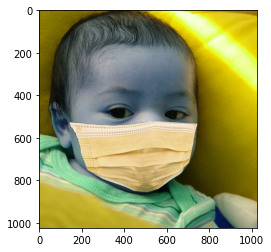

In [3]:
plt.imshow(img_array) ## BGR

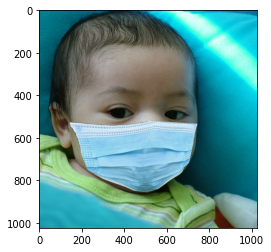

In [4]:
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))

In [5]:
img_array.shape

(1024, 1024, 3)

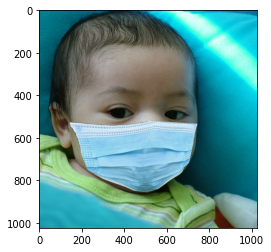

In [6]:
Datadirectory = "Dataset/"  ## training dataset
Classes = ["Face_Mask","No_Mask"] ## list of classes
for category in Classes:
    path = os.path.join(Datadirectory, category)  ## //
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        #backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

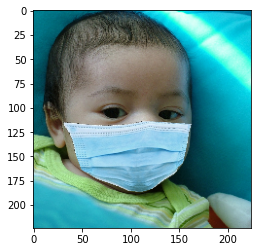

In [7]:
img_size= 224 ## ImageNet => 224 x 224

new_array= cv2.resize(img_array, (img_size,img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

# reading the images and converting all to array 

In [8]:
training_Data = [] ## data

def create_training_Data():
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category) ## 0 1,  ## Label
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array= cv2.resize(img_array, (img_size,img_size)) 
                training_Data.append([new_array,class_num])
            except Exception as e:
                pass

In [9]:
create_training_Data()

In [10]:
print(len(training_Data))

1951


In [11]:
import random

random.shuffle(training_Data)

In [12]:
X = []  ## data /feature
y = []  ## label

for features,label in training_Data:
    X.append(features)
    y.append(label)


X = np.array(X).reshape(-1, img_size, img_size, 3) 

In [13]:
X.shape

(1951, 224, 224, 3)

In [14]:
# normalize the data
X= X/255.0; ## we are normalizing it  

In [16]:
y[1000]

1

In [17]:
Y= np.array(y)

In [18]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

# deep learning model for training - Transfer Learning

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [21]:
model = tf.keras.applications.mobilenet.MobileNet() ## pre-trained model

In [22]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

# Transfer Learning  - Tuning , weights will start from last check point

In [24]:
base_input = model.layers[0].input

In [25]:
base_output= model.layers[-4].output

In [26]:
Flat_layer=  layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer) ## 0 ,1
final_ouput = layers.Activation('sigmoid')(final_output)

In [27]:
new_model = keras.Model(inputs = base_input, outputs= final_output)

In [28]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

# settings for binary classification  (Face mask / with out mask)

In [29]:
new_model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

new_model.fit(X,Y, epochs = 1,validation_split = 0.1)

In [31]:
new_model.save('my_model3.h5') 

In [32]:
new_model = tf.keras.models.load_model('my_model.h5')

# Checking the network for Predictions

In [34]:
frame = cv2.imread('00002_Mask.jpg')

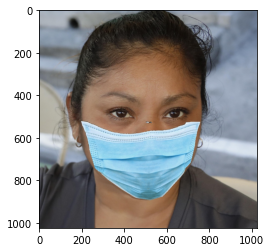

In [35]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [36]:
final_image =cv2.resize(frame, (224,224))
final_image =  np.expand_dims(final_image,axis =0)  ## need fourth dimension  
final_image=final_image/255.0

In [37]:
Predictions =new_model.predict(final_image)

In [38]:
Predictions

array([[-55.494904]], dtype=float32)

# checking the network for  unknown Images

In [40]:
frame = cv2.imread('sad_women.jpg')

In [45]:
frame.shape

(480, 852, 3)

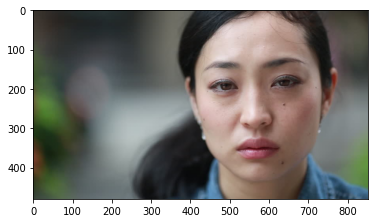

In [41]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [42]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [43]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [44]:
gray.shape

(480, 852)

In [46]:
faces = faceCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)   
    if len(facess) == 0:
        print("Face  not detected")
    else:
        for (ex,ey,ew,eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex + ew]

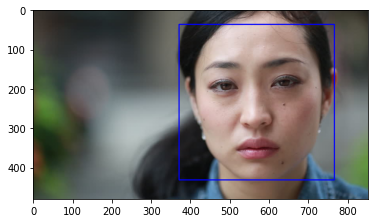

In [47]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

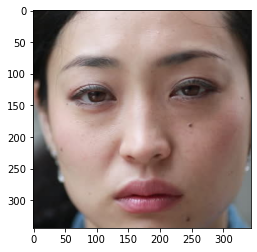

In [48]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [49]:
final_image =cv2.resize(face_roi, (224,224))
final_image =  np.expand_dims(final_image,axis =0)  ## need fourth dimension  
final_image=final_image/255.0

In [50]:
Predictions =new_model.predict(final_image)

In [51]:
Predictions

array([[38.855743]], dtype=float32)

# Realtime Video Demo

# Face Mask Detection

In [56]:

import cv2 ###  pip install opencv-python
 ## pip install opencv-contrib-python   fullpackage 
#from deepface import DeepFace  ## pip install deepface
path = "haarcascade_frontalface_default.xml"
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN

# set the rectangle background to white
rectangle_bgr = (255, 255, 255)
# make a black image
img = np.zeros((500, 500))
# set some text
text = "Some text in a box!"
# get the width and height of the text box
(text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]
# set the text start position
text_offset_x = 10
text_offset_y = img.shape[0] - 25
# make the coords of the box with a small padding of two pixels
box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale=font_scale, color=(0, 0, 0), thickness=1)

cap = cv2.VideoCapture(1)
# Check if the webcam is opened correctly
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:
    ret,frame = cap.read()
    #eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_eye.xml')
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #print(faceCascade.empty())
    faces = faceCascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        facess = faceCascade.detectMultiScale(roi_gray)   
        if len(facess) == 0:
            print("Face  not detected")
        else:
            for (ex,ey,ew,eh) in facess:
                face_roi = roi_color[ey: ey+eh, ex:ex + ew] ## cropping the face
    
    final_image =cv2.resize(face_roi, (224,224))
    final_image =  np.expand_dims(final_image,axis =0)  ## need fourth dimension  
    final_image=final_image/255.0
    
    font = cv2.FONT_HERSHEY_SIMPLEX 
    
    Predictions = new_model.predict(final_image)
    
    font_scale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN

 
    if (Predictions>0):
        status = "No Mask"
        
        x1,y1,w1,h1 = 0,0,175,75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        
        cv2.putText(frame,status,(100, 150),font, 3,(0, 0, 255),2,cv2.LINE_4)
       
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255))
    else:
        status = "Face Mask"
        
        x1,y1,w1,h1 = 0,0,175,75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        cv2.putText(frame,status,(100, 150),font, 3,(0, 255,0),2,cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255,0))
    
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #print(faceCascade.empty())
    #faces = faceCascade.detectMultiScale(gray,1.1,4)

    # Draw a rectangle around the faces
    #for(x, y, w, h) in faces:
      #  cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
 
   
    
  
    # Use putText() method for 
    # inserting text on video 
  
    cv2.imshow('Face Mask Detection Tutorial',frame)

    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected


KeyboardInterrupt: 

# Lets add some beeps

In [ ]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second

import cv2 ###  pip install opencv-python
 ## pip install opencv-contrib-python   fullpackage 
#from deepface import DeepFace  ## pip install deepface
path = "haarcascade_frontalface_default.xml"
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN

# set the rectangle background to white
rectangle_bgr = (255, 255, 255)
# make a black image
img = np.zeros((500, 500))
# set some text
text = "Some text in a box!"
# get the width and height of the text box
(text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]
# set the text start position
text_offset_x = 10
text_offset_y = img.shape[0] - 25
# make the coords of the box with a small padding of two pixels
box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height - 2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale=font_scale, color=(0, 0, 0), thickness=1)

cap = cv2.VideoCapture(1)
# Check if the webcam is opened correctly
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:
    ret,frame = cap.read()
    #eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_eye.xml')
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #print(faceCascade.empty())
    faces = faceCascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        facess = faceCascade.detectMultiScale(roi_gray)   
        if len(facess) == 0:
            print("Face  not detected")
        else:
            for (ex,ey,ew,eh) in facess:
                face_roi = roi_color[ey: ey+eh, ex:ex + ew] ## cropping the face
    
    final_image =cv2.resize(face_roi, (224,224))
    final_image =  np.expand_dims(final_image,axis =0)  ## need fourth dimension  
    final_image=final_image/255.0
    
    font = cv2.FONT_HERSHEY_SIMPLEX 
    
    Predictions = new_model.predict(final_image)
    
    font_scale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN

 
    if (Predictions>0):
        status = "No Mask"
        
        x1,y1,w1,h1 = 0,0,175,75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
        
        cv2.putText(frame,status,(100, 150),font, 3,(0, 0, 255),2,cv2.LINE_4)
       
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255))
        winsound.Beep(frequency, duration)
    else:
        status = "Face Mask"
        
        x1,y1,w1,h1 = 0,0,175,75
        # Draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0,0,0), -1)
        # Add text
        cv2.putText(frame, status, (x1 + int(w1/10),y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        cv2.putText(frame,status,(100, 150),font, 3,(0, 255,0),2,cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255,0))
    
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #print(faceCascade.empty())
    #faces = faceCascade.detectMultiScale(gray,1.1,4)

    # Draw a rectangle around the faces
    #for(x, y, w, h) in faces:
      #  cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
 
   
    
  
    # Use putText() method for 
    # inserting text on video 
  
    cv2.imshow('Face Mask Detection Tutorial',frame)

    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not detected
Face  not de